In [8]:
import requests
data = requests.get(
"https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)
with open('iris.data', 'w') as f:
    f.write(data.text)

In [22]:
from typing import Dict, List, NamedTuple
Vector = List[float]
import csv
from collections import defaultdict 
class LabeledPoint(NamedTuple):
    point: Vector
    label: str
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]
    return LabeledPoint(measurements, label)
with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]
# We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

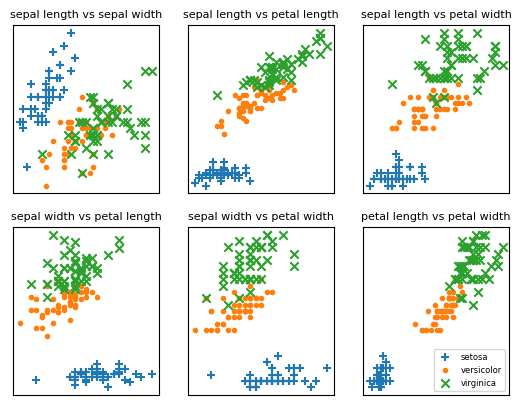

In [26]:
from matplotlib import pyplot as plt
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x'] # we have 3 classes, so 3 markers
fig, ax = plt.subplots(2, 3)
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
         
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)
ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()
 

In [27]:
import random
from scratch.machine_learning import split_data
random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [40]:
from typing import Tuple
import math
from collections import Counter
def subtract(v: Vector, w: Vector) -> Vector:
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"

    return [v_i - w_i for v_i, w_i in zip(v, w)]
def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))
def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)
def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))
def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                        for count in vote_counts.values()
                        if count == winner_count])
    if num_winners == 1:
        return winner # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest
def knn_classify(k: int,
    labeled_points: List[LabeledPoint],
    new_point: Vector) -> str:
    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                        key=lambda lp: distance(lp.point, new_point))
    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    # and let them vote.
    return majority_vote(k_nearest_labels)
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0
for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    if predicted == actual:
        num_correct += 1
    confusion_matrix[(predicted, actual)] += 1
pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


Curse of Dimensionality: 100%|████████████████| 100/100 [00:22<00:00,  4.49it/s]


100 100


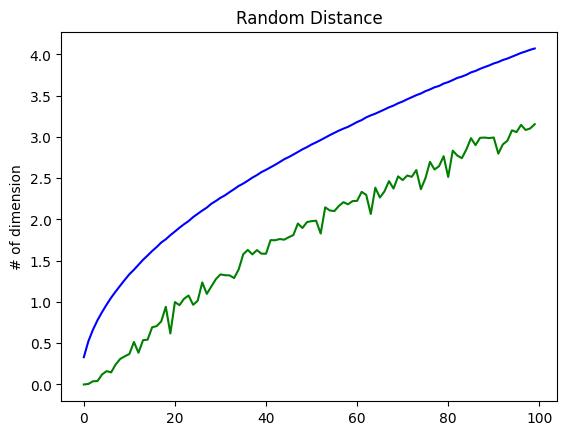

In [53]:
import tqdm
from matplotlib import pyplot as plt
dimensions = range(1, 101)
avg_distances = []
min_distances = []
random.seed(0)
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000) # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000) # track the average
    min_distances.append(min(distances)) # track the minimum
min_avg_ratio = [min_dist / avg_dist
            for min_dist, avg_dist in zip(min_distances, avg_distances)]
print(len(avg_distances),len(min_distances))
indx = []

j = 0
for i in avg_distances :
    indx.append(j)
    j = j+1
    

min_avg_ratio = [min_dist / avg_dist
                    for min_dist, avg_dist in zip(min_distances, avg_distances)]

plt.plot(indx, avg_distances, color='blue',    linestyle='solid')
plt.plot(indx, min_distances, color='green',   linestyle='solid') 
# add a title
plt.title("Random Distance")
# add a label to the y-axis
plt.ylabel("# of dimension")
plt.show()

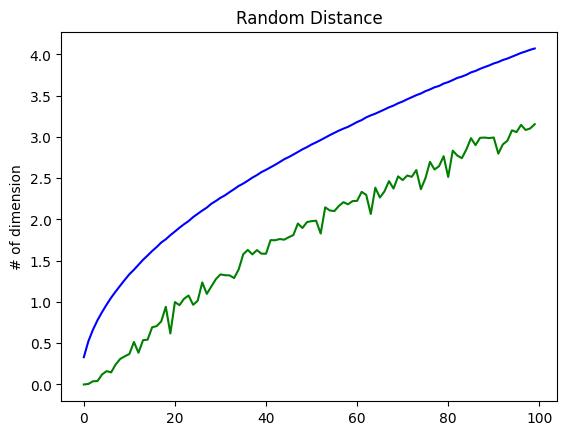

In [54]:
plt.plot(indx, avg_distances, color='blue',    linestyle='solid')
plt.plot(indx, min_distances, color='green',   linestyle='solid') 
# add a title
plt.title("Random Distance")
# add a label to the y-axis
plt.ylabel("# of dimension")
plt.show()

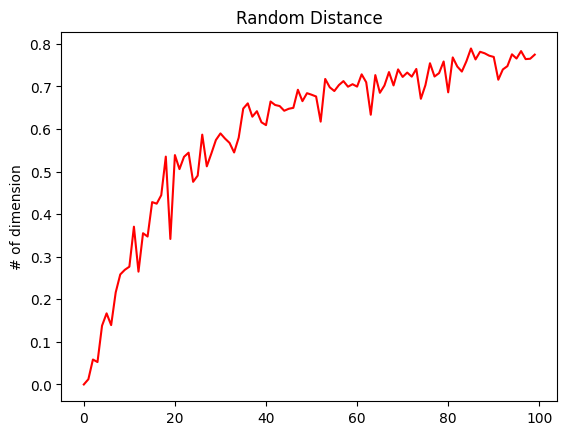

In [55]:

plt.plot(indx, min_avg_ratio, color='red',   linestyle='solid')
# add a title
plt.title("Min / AVG Distance")
# add a label to the y-axis
plt.ylabel("# of dimension")
plt.show()